In [1]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
class FilterType(Enum):
    FREQUENCY_PASS = "Filtr przepustowy"
    MOVING_AVERAGE = "Filtr średniej kroczącej"

In [3]:
class KernelType(Enum):
    GAUSSIAN = "Jądro Gaussa"
    BLACKMAN = "Jądro Blackmana"
    HAMMING = "Jądro Hamminga"
    BOX = "Jądro prostokątne"

In [4]:
class FrequencyPassType(Enum):
    LOW = "Dolnoprzepustowy"
    HIGH = "Górnoprzepustowy"
    BAND = "Pasmowoprzepustowy"

In [5]:
class Sin:
    def __init__(self, freq, amplitude, phase):
        self.freq = freq
        self.amplitude = amplitude
        self.phase = phase

    def generate_signal(self, time):
        return self.amplitude * np.sin(2 * np.pi * self.freq * time + self.phase)
    
    def __str__(self):
        return f"Sin(freq={self.freq}, amplitude={self.amplitude}, phase={self.phase})"
        

In [6]:
def generate_unit_impulse(time, impulse_time):
    impulse = np.zeros(len(time))
    impulse[impulse_time] = 1
    return impulse

In [7]:
def generate_unit_step(time, step_time):
    step = np.zeros(len(time))
    step[step_time:] = 1
    return step

In [8]:
class LowpassFilter:
    def __init__(self, cutoff, sampling, order=5):
        self.cutoff = cutoff
        self.sampling = sampling
        self.order = order
        self.sos = signal.butter(order, cutoff, 'low', False, 'sos', sampling)
        
    def filter(self, data):
        return signal.sosfilt(self.sos, data)
    
    def __str__(self):
        return f"LowpassFilter(cutoff={self.cutoff}, sampling={self.sampling}, order={self.order})"

In [9]:
class HighpassFilter:
    def __init__(self, cutoff, sampling, order=5):
        self.cutoff = cutoff
        self.sampling = sampling
        self.order = order
        self.sos = signal.butter(order, cutoff, 'high', False, 'sos', sampling)
        
    def filter(self, data):
        return signal.sosfilt(self.sos, data)
    
    def __str__(self):
        return f"HighpassFilter(cutoff={self.cutoff}, sampling={self.sampling}, order={self.order})"

In [10]:
class BandpassFilter:
    def __init__(self, lowcut, highcut, sampling, order=5):
        self.lowcut = lowcut
        self.highcut = highcut
        self.sampling = sampling
        self.order = order
        self.sos = signal.butter(order, [lowcut, highcut], 'band', False, 'sos', sampling)
        
    def filter(self, data):
        return signal.sosfilt(self.sos, data)
    
    def __str__(self):
        return f"BandpassFilter(lowcut={self.lowcut}, highcut={self.highcut}, sampling={self.sampling}, order={self.order})"

In [11]:
class MovingAverageFilter:
    def __init__(self, kernel_type, kernel_size):
        self.kernel = self.generate_kernel(kernel_type, kernel_size)
        self.kernel_size = kernel_size

    def generate_kernel(self, kernel_type, kernel_size):
        if kernel_type == KernelType.GAUSSIAN:
            return signal.windows.gaussian(kernel_size, std=3)
        elif kernel_type == KernelType.BLACKMAN:
            return signal.windows.blackman(kernel_size)
        elif kernel_type == KernelType.HAMMING:
            return signal.windows.hamming(kernel_size)
        elif kernel_type == KernelType.BOX:
            return np.ones(kernel_size)
        
    def filter(self, data):
        return signal.convolve(data, self.kernel, mode='same') / self.kernel_size
    
    def __str__(self):
        return f"MovingAverageFilter(kernel_size={self.kernel_size})"

In [12]:
def combine_signals(signals):
    result_signal = np.zeros(len(signals[0]))
    for i in range(len(signals)):
        result_signal += signals[i]
    return result_signal

In [13]:
def plot_signals(signals: list[list[any]], labels: list[list[any]], titles: list[str], xlabels: list[str], ylabels: list[str], sampling, return_plot=False):
    plot, axes = plt.subplots(len(signals), 1, figsize=(14, 3 * len(signals)), sharex=True)

    if len(signals) == 1:
        axes = [axes]


    for i in range(len(signals)):
        for j in range(len(signals[i])):
            axes[i].plot(signals[i][j], label=labels[i][j])
            axes[i].set_title(titles[i])
            axes[i].set_xlabel(xlabels[i])
            axes[i].set_ylabel(ylabels[i])
            axes[i].set_ylim(-3, 3)
            axes[i].legend()
            axes[i].set_xticks(np.arange(0, len(signals[i][j]), 100), np.round(np.arange(0, len(signals[i][j]), 100) / sampling, 2))

    return plot if return_plot else None

In [14]:
def plot_signal_responses(filter, sampling, title=None, show_freq_response=False, return_plot=False):
    plot, axes = plt.subplots(1, 3 if show_freq_response else 2, figsize=(14, 5))

    if title is not None:
        plot.suptitle(title)


    unit_impulse = generate_unit_impulse(np.arange(0, 1, 1 / sampling), sampling // 2)
    unit_step = generate_unit_step(np.arange(0, 1, 1 / sampling), sampling // 2)

    range = round(min((0.9 * sampling) // 2, 100))

    unit_impulse_response = filter.filter(unit_impulse)[sampling // 2 - range:sampling // 2 + range]
    unit_step_response = filter.filter(unit_step)[sampling // 2 - range:sampling // 2 + range]

    axes[0].plot(unit_impulse_response)
    axes[0].set_title("Odpowiedź impulsowa")
    axes[0].set_xlabel("Czas [Sekundy]")
    axes[0].set_ylabel("Wartość [amplituda]")
    axes[0].set_xticks(np.arange(0, 2 * range + 1, range // 4), np.round(np.arange(sampling // 2 - range, sampling // 2 + range + 1, range // 4) / sampling, 2))

    axes[1].plot(unit_step_response)
    axes[1].set_title("Odpowiedź skokowa")
    axes[1].set_xlabel("Czas [Sekundy]")
    axes[1].set_ylabel("Wartość [amplituda]")
    axes[1].set_xticks(np.arange(0, 2 * range + 1, range // 4), np.round(np.arange(sampling // 2 - range, sampling // 2 + range + 1, range // 4) / sampling, 2))

    if show_freq_response:
        w, h = signal.sosfreqz(filter.sos)
        axes[2].semilogx(w, 20 * np.log10(abs(h)), 'b')
        axes[2].set_ylabel('Amplituda [dB]', color='b')
        axes[2].set_xlabel('Częstotliwość')
        axes[2].set_title("Odpowiedź częstotliwościowa")

    return plot if return_plot else None


In [15]:
samples = 1000
sampling = 1000
kernel_size = 100

## Przykład generowania sygnału sinusoidalnego

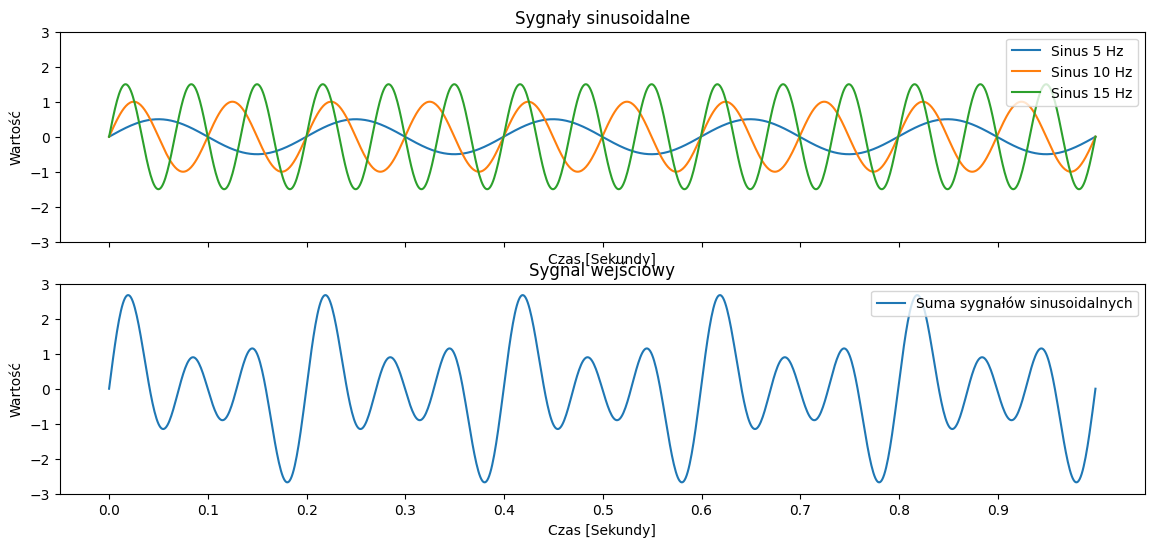

In [16]:
sin_a = Sin(5, 0.5, 0)
sin_b = Sin(10, 1, 0)
sin_c = Sin(15, 1.5, 0)

sin_a_signal = sin_a.generate_signal(np.linspace(0, 1, samples))
sin_b_signal = sin_b.generate_signal(np.linspace(0, 1, samples))
sin_c_signal = sin_c.generate_signal(np.linspace(0, 1, samples))

sin_combined = combine_signals([sin_a_signal, sin_b_signal, sin_c_signal])

plot_signals(
    [[sin_a_signal, sin_b_signal, sin_c_signal], [sin_combined]], 
    [["Sinus 5 Hz", "Sinus 10 Hz", "Sinus 15 Hz"], ["Suma sygnałów sinusoidalnych"]], 
    ['Sygnały sinusoidalne', 'Sygnal wejściowy'], 
    ['Czas [Sekundy]','Czas [Sekundy]'],
    ['Wartość', 'Wartość'],
    sampling
)



## Filtrowanie utworzonego powyżej sygnału za pomocą filtra dolnoprzepustowego o odcięciu 6 Hz 

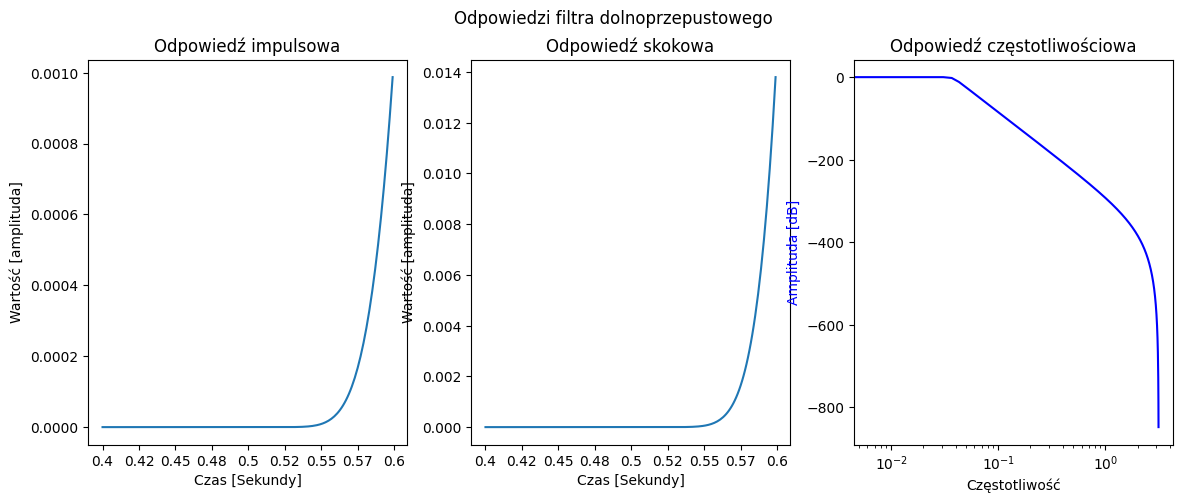

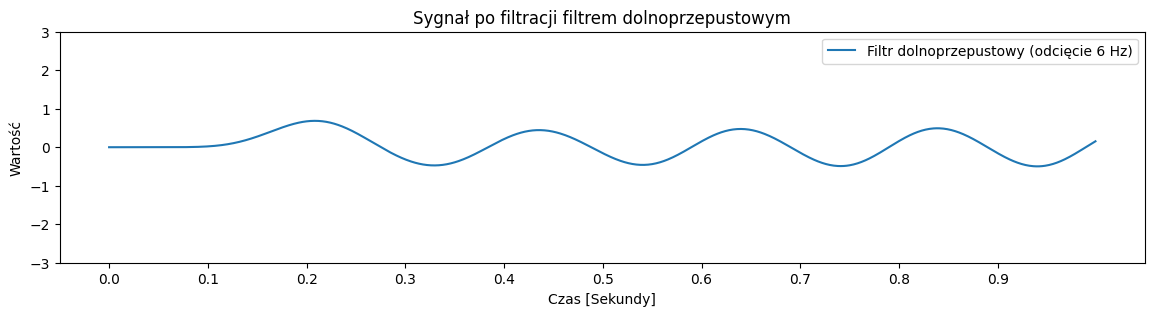

In [17]:
lowpass_filter = LowpassFilter(6, sampling, 10)
lowpass = lowpass_filter.filter(sin_combined)

plot_signal_responses(lowpass_filter, samples, "Odpowiedzi filtra dolnoprzepustowego", True)
plot_signals([[lowpass]], [["Filtr dolnoprzepustowy (odcięcie 6 Hz)"]], ['Sygnał po filtracji filtrem dolnoprzepustowym'], ['Czas [Sekundy]'], ['Wartość'], sampling)


## Filtrowanie utworzonego powyżej sygnału za pomocą filtra pasmowoprzepustowego przepuszczającego sygnały o częstotliwościach z zakresu 6-12 Hz 

C:\Users\micha\AppData\Local\Temp\ipykernel_2156\3952370404.py:30: RuntimeWarning: divide by zero encountered in log10
  axes[2].semilogx(w, 20 * np.log10(abs(h)), 'b')


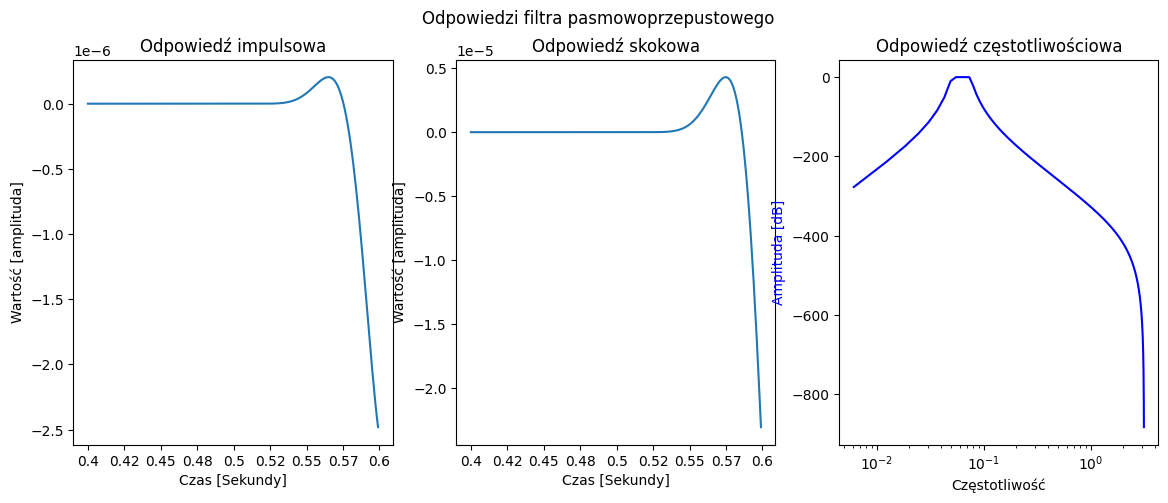

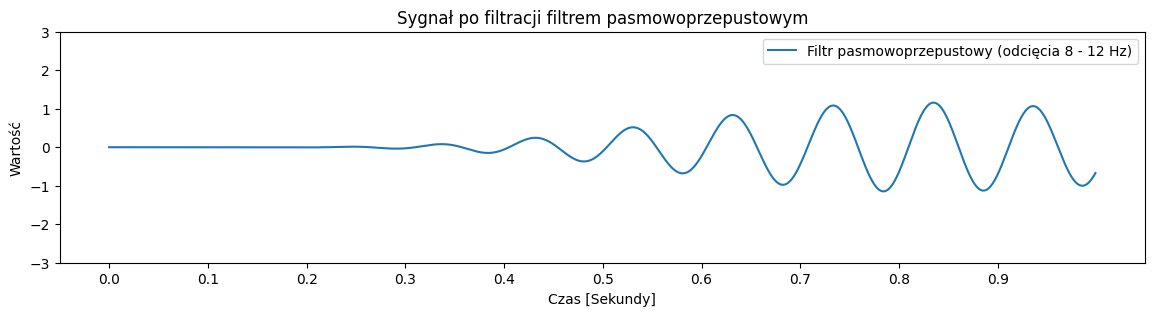

In [18]:
bandpass_filter = BandpassFilter(8, 12, sampling, 10)
bandpass = bandpass_filter.filter(sin_combined)

plot_signal_responses(bandpass_filter, samples, "Odpowiedzi filtra pasmowoprzepustowego", True)
plot_signals([[bandpass]], [["Filtr pasmowoprzepustowy (odcięcia 8 - 12 Hz)"]], ['Sygnał po filtracji filtrem pasmowoprzepustowym'], ['Czas [Sekundy]'], ['Wartość'], sampling)


## Filtrowanie utworzonego powyżej sygnału za pomocą filtra górnoprzepustowego o odcięciu 14 Hz 

C:\Users\micha\AppData\Local\Temp\ipykernel_2156\3952370404.py:30: RuntimeWarning: divide by zero encountered in log10
  axes[2].semilogx(w, 20 * np.log10(abs(h)), 'b')


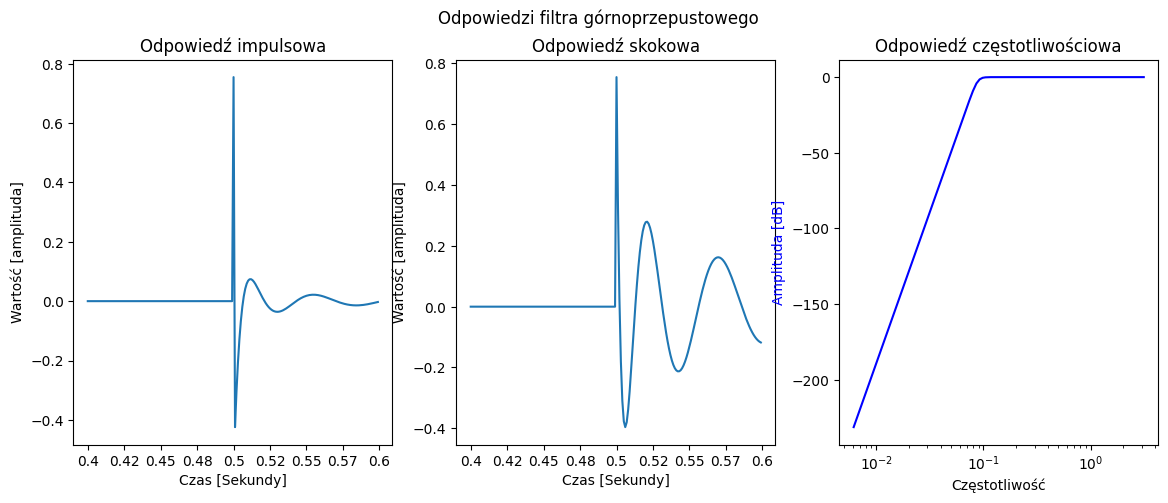

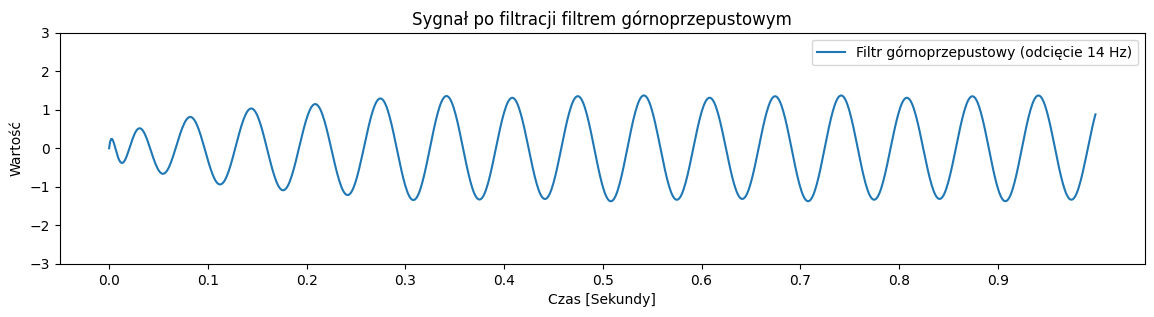

In [19]:
highpass_filter = HighpassFilter(14, sampling, 10)
highpass = highpass_filter.filter(sin_combined)

plot_signal_responses(highpass_filter, samples, "Odpowiedzi filtra górnoprzepustowego", True)
plot_signals([[highpass]], [["Filtr górnoprzepustowy (odcięcie 14 Hz)"]], ['Sygnał po filtracji filtrem górnoprzepustowym'], ['Czas [Sekundy]'], ['Wartość'], sampling)


## Odtwarzanie składowych sinusoidalnych sygnału za pomocą filtrów przepustowych

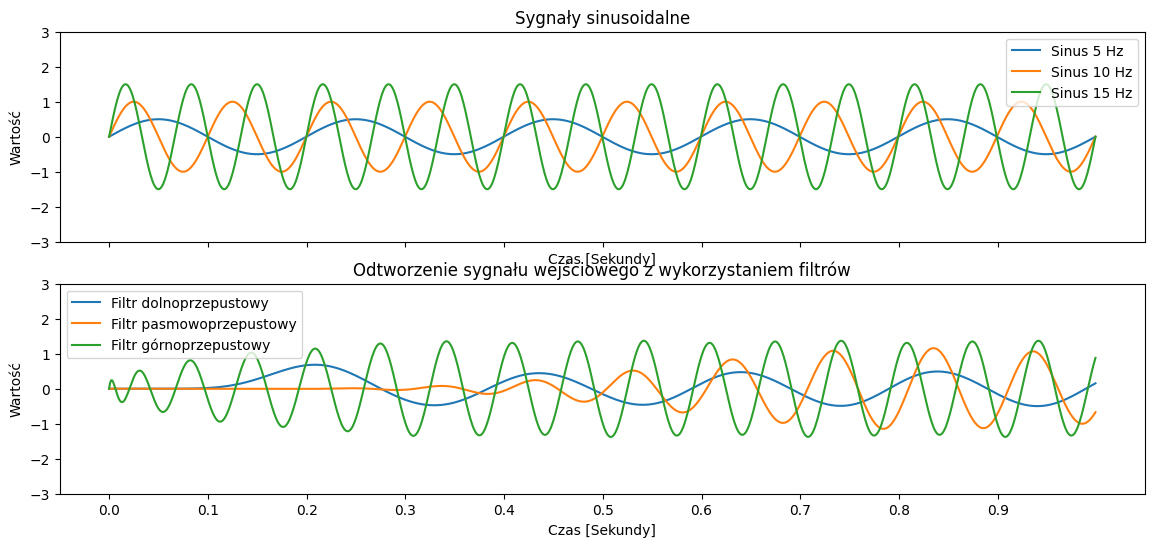

In [20]:
plot_signals(
    [[sin_a_signal, sin_b_signal, sin_c_signal], [lowpass, bandpass, highpass]], 
    [["Sinus 5 Hz", "Sinus 10 Hz", "Sinus 15 Hz"], ["Filtr dolnoprzepustowy", "Filtr pasmowoprzepustowy", "Filtr górnoprzepustowy"]], 
    ['Sygnały sinusoidalne', 'Odtworzenie sygnału wejściowego z wykorzystaniem filtrów'], 
    ['Czas [Sekundy]','Czas [Sekundy]'],
    ['Wartość', 'Wartość'],
    sampling
)


## Przykład wykorzystania filtru o średniej kroczącej

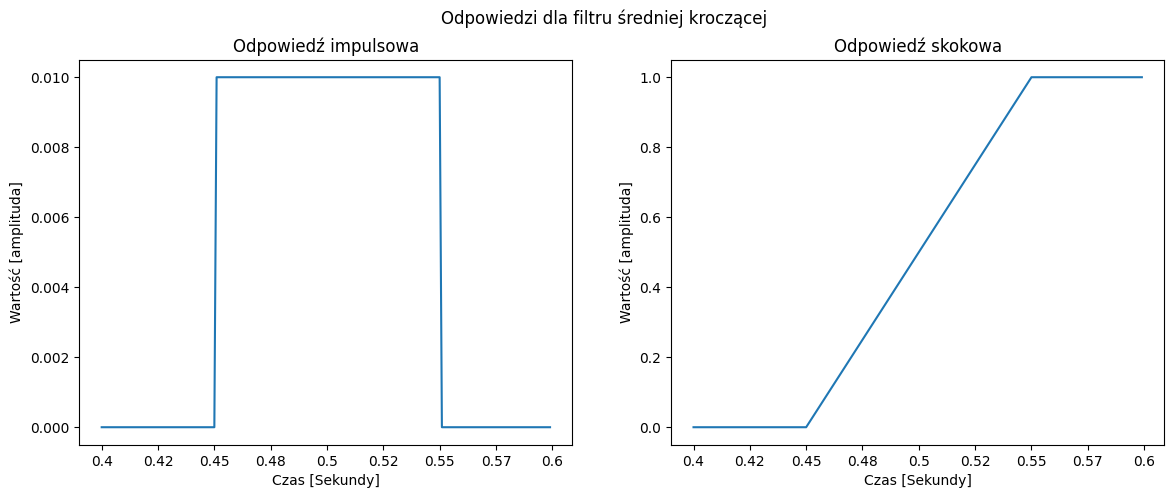

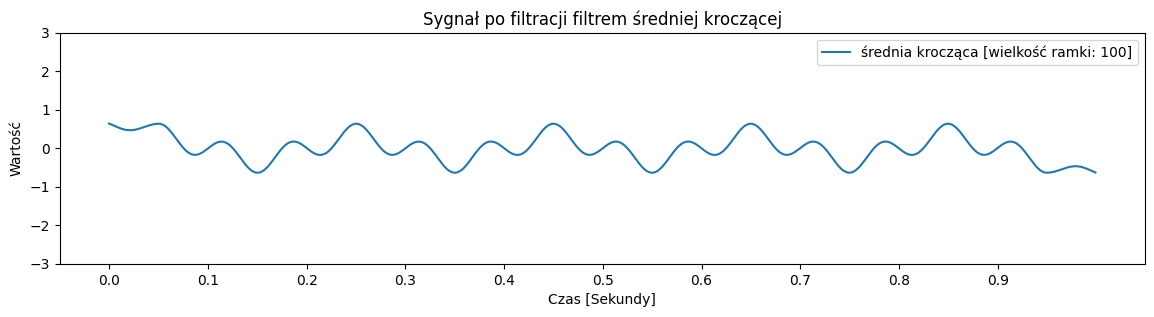

In [21]:
moving_average_filter = MovingAverageFilter(KernelType.BOX, kernel_size)
moving_average = moving_average_filter.filter(sin_combined)

plot_signal_responses(moving_average_filter, samples, "Odpowiedzi dla filtru średniej kroczącej")
plot_signals([[moving_average]], [["średnia krocząca [wielkość ramki: " + str(kernel_size) + "]"]], ['Sygnał po filtracji filtrem średniej kroczącej'], ['Czas [Sekundy]'], ['Wartość'], sampling)


## Przykład wykorzystania filtru o jądrze Gaussowskim

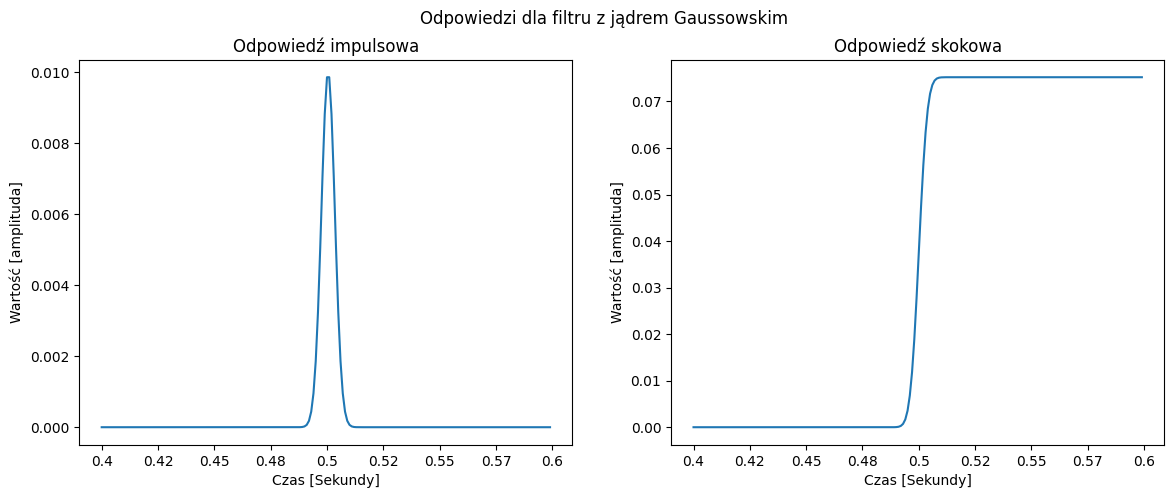

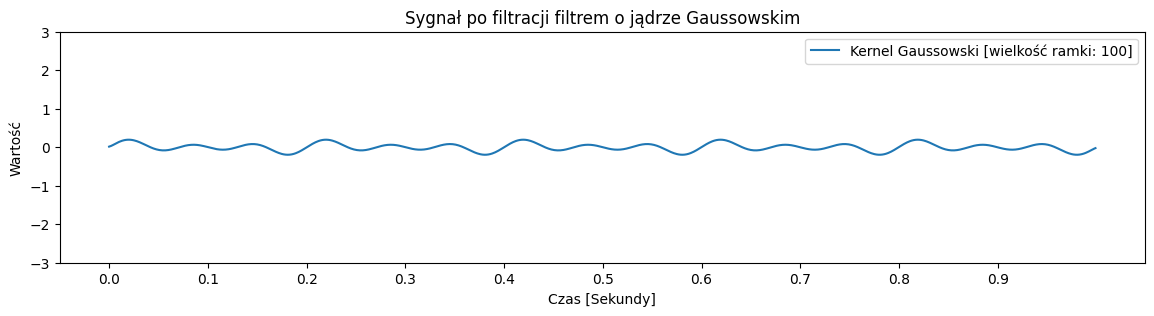

In [22]:
gaussian_filter = MovingAverageFilter(KernelType.GAUSSIAN, kernel_size)
gaussian = gaussian_filter.filter(sin_combined)

plot_signal_responses(gaussian_filter, samples, "Odpowiedzi dla filtru z jądrem Gaussowskim")
plot_signals([[gaussian]], [["Kernel Gaussowski [wielkość ramki: " + str(kernel_size) + "]"]], ['Sygnał po filtracji filtrem o jądrze Gaussowskim'], ['Czas [Sekundy]'], ['Wartość'], sampling)


In [23]:
class MovingAverageFilterHandler:
    def __init__(
            self, 
            kernel_type: KernelType = None, 
            kernel_size: int = None, 
            sampling: int = None, 
            samples: int = None, 
            signal: np.array = None,
            selected_channel: int = None
        ):
        self.kernel_type = kernel_type
        self.kernel_size = kernel_size
        self.sampling = sampling
        self.samples = samples
        self.signal = signal
        self.selected_channel = selected_channel

        if self.signal is not None:
            if self.signal.ndim == 1:
                self.signal = np.array([self.signal])

            if self.samples is None or self.samples > len(self.signal[0]):
                self.samples = len(self.signal[0])

            if self.sampling is None:
                self.sampling = self.samples

            if self.selected_channel is None or self.selected_channel >= len(self.signal):
                self.selected_channel = 0
        
        self.filtered_signal = None
        self.filter_plot = None
        self.signal_plot = None
        self.filtered_signal_plot = None

    def read_signal_from_file(self, path: str):
        self.signal = np.loadtxt(path, delimiter=';').transpose()

        if self.signal.ndim == 1:
            self.signal = np.array([self.signal])

        if self.samples is None or self.samples > len(self.signal[0]):
            self.samples = len(self.signal[0])

        if self.sampling is None:
            self.sampling = self.samples

        if self.selected_channel is None or self.selected_channel >= len(self.signal):
            self.selected_channel = 0


    def filter_signal(self):
        if self.kernel_type is None or self.kernel_size is None or self.signal is None:
            return

        self.filter = MovingAverageFilter(self.kernel_type, self.kernel_size)
        self.filtered_signal = self.filter.filter(self.signal[self.selected_channel])


    def plot_result(self):
        if self.filter is None \
            or self.signal is None \
            or self.filtered_signal is None \
            or self.sampling is None \
            or self.samples is None \
            or self.selected_channel is None:
            return

        self.filter_plot = plot_signal_responses(self.filter, self.sampling, "Odpowiedzi dla filtru średniej kroczącej", False, True)
        self.signal_plot = plot_signals([[self.signal[self.selected_channel]]], [["Sygnał wejściowy"]], ["Sygnał wejściowy"], ["Czas [Sekundy]"], ["Wartość"], self.sampling, True)
        self.filtered_signal_plot = plot_signals([[self.filtered_signal]], [["Przefiltrowany sygnał"]], ["Przefiltrowany sygnał"], ["Czas [Sekundy]"], ["Wartość"], self.sampling, True)


    def save_filtered_signal(self, path: str):
        if self.filtered_signal is None:
            return

        np.savetxt(path, self.filtered_signal, delimiter=';')


        

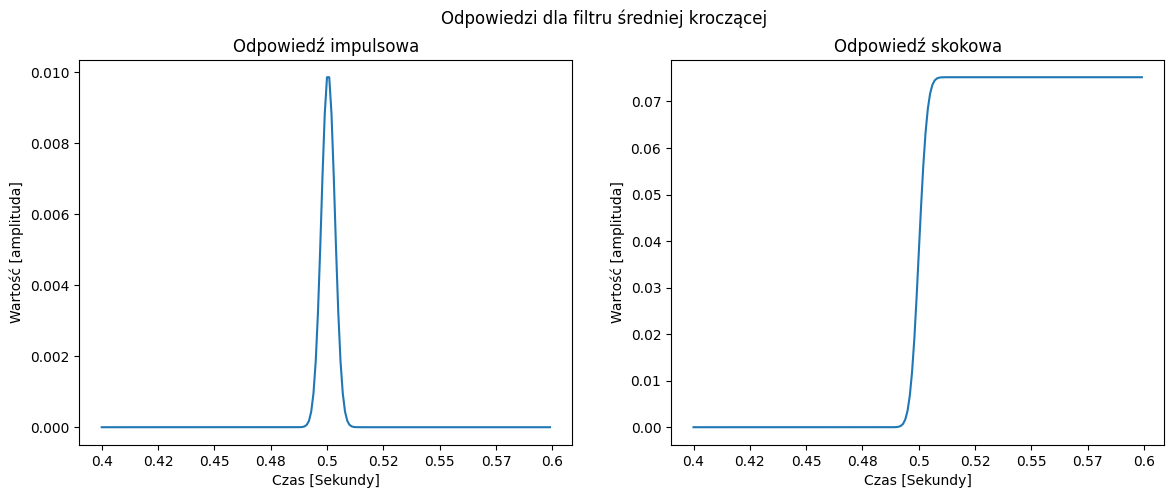

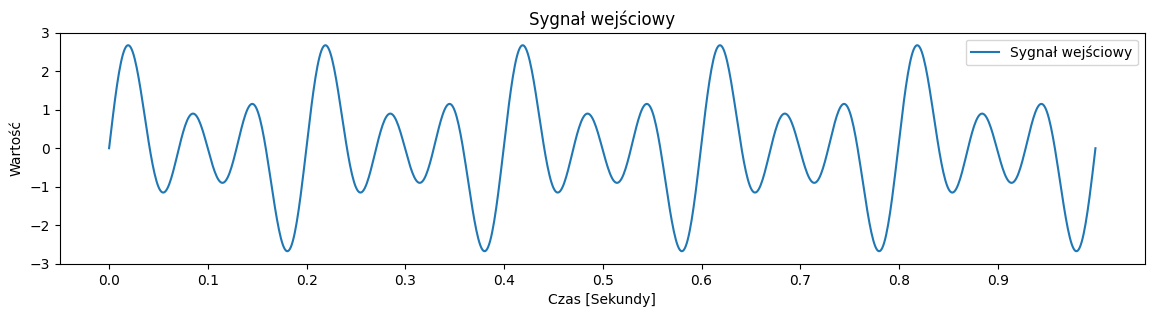

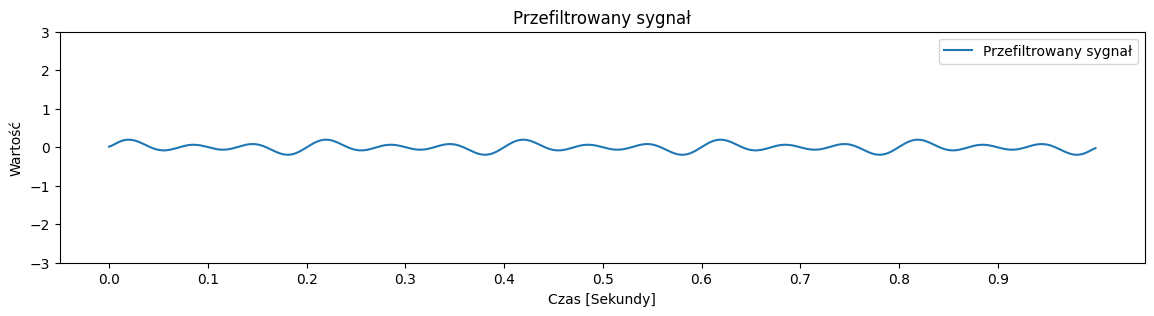

In [24]:
movingAvgFilter = MovingAverageFilterHandler(KernelType.GAUSSIAN, 100, sampling, samples, np.array([sin_combined]))
movingAvgFilter.filter_signal()
movingAvgFilter.plot_result()
movingAvgFilter.save_filtered_signal("filtered_signal.csv")

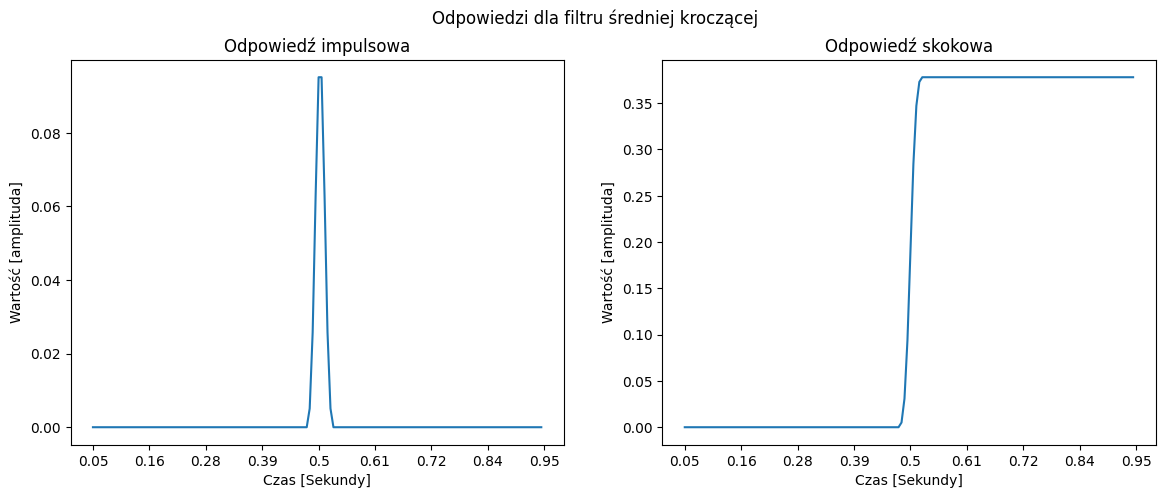

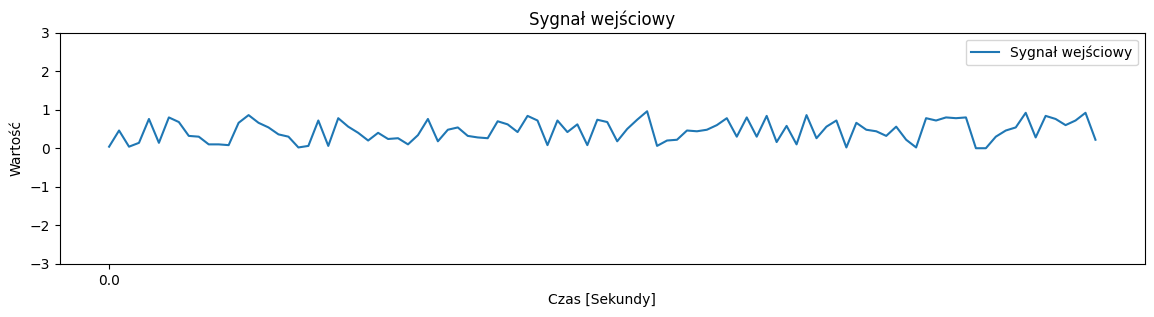

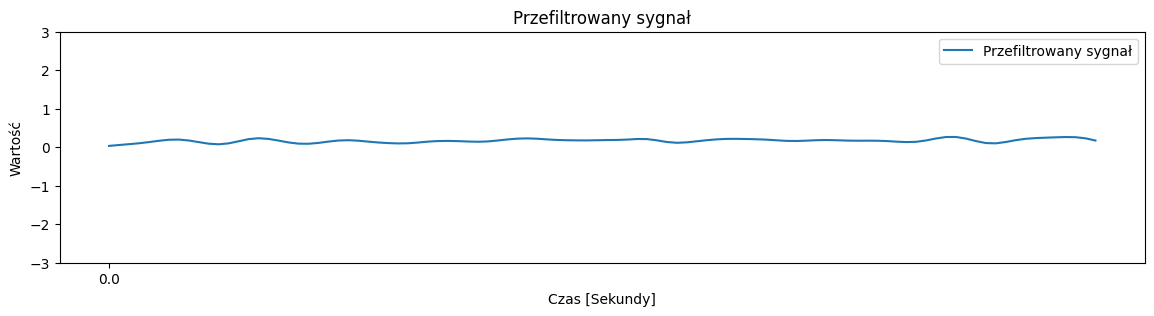

In [25]:
movingAvgFilter = MovingAverageFilterHandler(KernelType.BLACKMAN, 10, 170)
movingAvgFilter.read_signal_from_file("Dane/szum2_1_100.csv")
movingAvgFilter.filter_signal()
movingAvgFilter.plot_result()
movingAvgFilter.save_filtered_signal("filtered_signal.csv")

In [26]:
class FrequencyPassFilterHandler:
    def __init__(
            self, 
            frequency_pass_type: FrequencyPassType = None,
            cutoff_low: float = None,
            cutoff_high: float = None,
            sampling: int = None, 
            samples: int = None, 
            signal: np.array = None,
            order: int = None,
            selected_channel: int = None
        ):
        self.frequency_pass_type = frequency_pass_type
        self.cutoff_low = cutoff_low
        self.cutoff_high = cutoff_high
        self.sampling = sampling
        self.samples = samples
        self.signal = signal
        self.order = order
        self.selected_channel = selected_channel
        self.filter = None


        if self.signal is not None:
            if self.signal.ndim == 1:
                self.signal = np.array([self.signal])
            if self.samples is None or self.samples > len(self.signal[0]):
                self.samples = len(self.signal[0])

            if self.sampling is None or self.sampling > self.samples:
                self.sampling = 1000

            if self.selected_channel is None or self.selected_channel >= len(self.signal):
                self.selected_channel = 0
        
        self.filtered_signal = None
        self.filter_plot = None
        self.signal_plot = None
        self.filtered_signal_plot = None

    def read_signal_from_file(self, path: str):
        self.signal = np.loadtxt(path, delimiter=';').transpose()

        print(self.signal.ndim)

        if self.signal.ndim == 1:
            self.signal = np.array([self.signal])

        if self.samples is None or self.samples > len(self.signal[0]):
            self.samples = len(self.signal[0])

        if self.sampling is None or self.sampling > self.samples:
            self.sampling = 1000

        if self.selected_channel is None or self.selected_channel >= len(self.signal):
            self.selected_channel = 0


    def filter_signal(self):
        if self.frequency_pass_type is None \
            or self.signal is None \
            or self.sampling is None \
            or self.samples is None \
            or self.order is None \
            or self.selected_channel is None:
            return
        
        order = self.order if self.order is not None else 10

        if self.frequency_pass_type == FrequencyPassType.LOW:
            if self.cutoff_low is None:
                return
            
            self.filter = LowpassFilter(self.cutoff_low, self.sampling, order)
        elif self.frequency_pass_type == FrequencyPassType.HIGH:
            if self.cutoff_high is None:
                return
            
            self.filter = HighpassFilter(self.cutoff_high, self.sampling, order)
        else:
            if self.cutoff_low is None or self.cutoff_high is None:
                return
            
            self.filter = BandpassFilter(self.cutoff_low, self.cutoff_high, self.sampling, order)

        self.filtered_signal = self.filter.filter(self.signal[self.selected_channel])


    def plot_result(self):
        if self.filter is None or self.signal is None or self.filtered_signal is None or self.sampling is None or self.samples is None:
            return

        self.filter_plot = plot_signal_responses(self.filter, self.sampling, "Odpowiedzi dla filtru " + self.frequency_pass_type.value, True, True)
        self.signal_plot = plot_signals([[self.signal[self.selected_channel]]], [["Sygnał wejściowy"]], ["Sygnał wejściowy"], ["Czas [Sekundy]"], ["Wartość"], self.sampling, True)
        self.filtered_signal_plot = plot_signals([[self.filtered_signal]], [["Przefiltrowany sygnał"]], ["Przefiltrowany sygnał"], ["Czas [Sekundy]"], ["Wartość"], self.sampling, True)


    def save_filtered_signal(self, path: str):
        if self.filtered_signal is None:
            return

        np.savetxt(path, self.filtered_signal, delimiter=';')

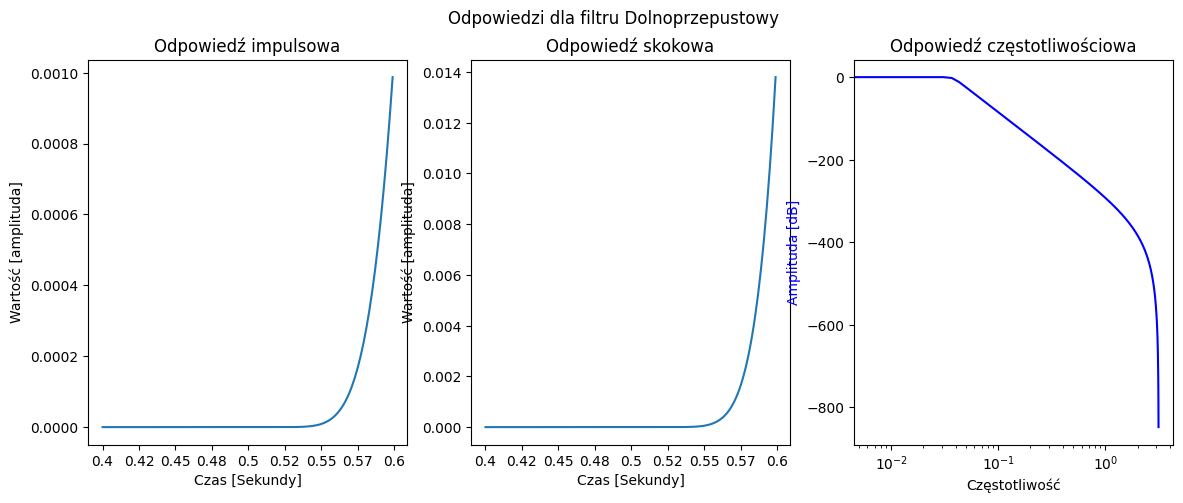

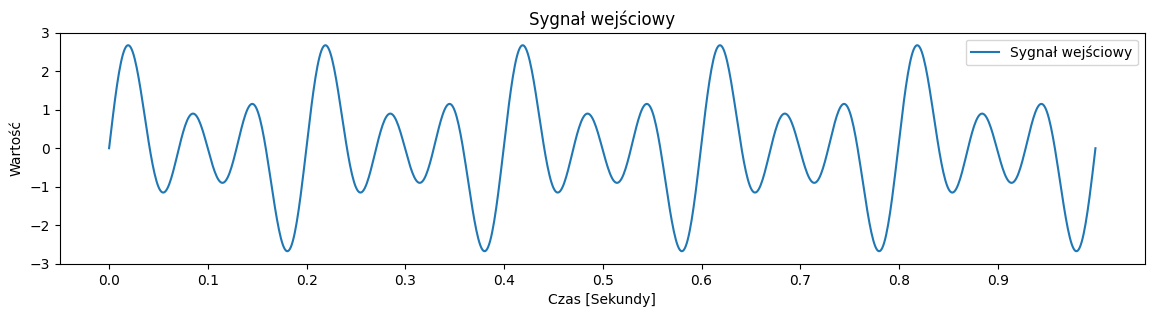

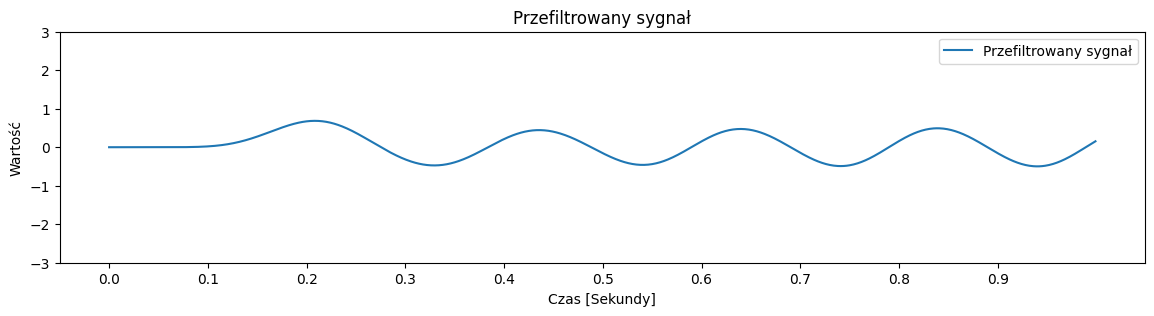

In [27]:
freqPassFilter = FrequencyPassFilterHandler(FrequencyPassType.LOW, 6, 12, sampling, samples, np.array([sin_combined]), 10)
freqPassFilter.filter_signal()
freqPassFilter.plot_result()
freqPassFilter.save_filtered_signal("filtered_signal.csv")

1


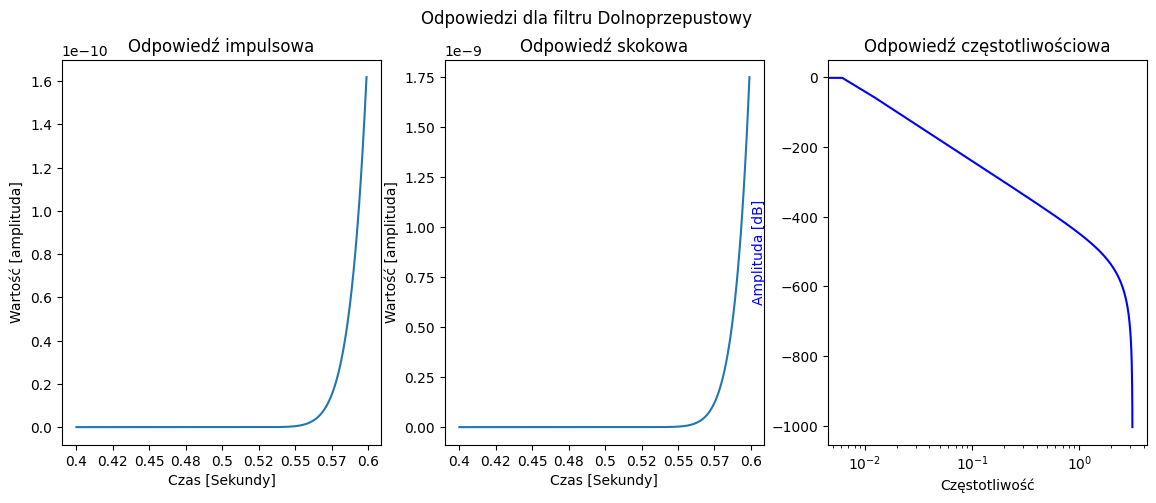

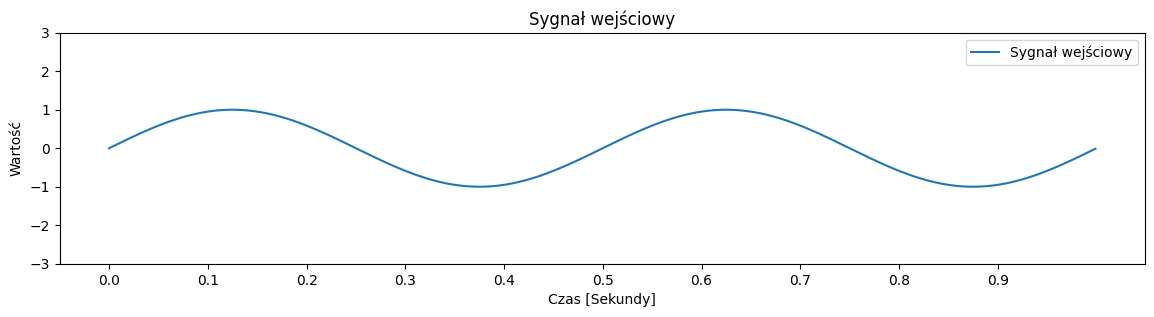

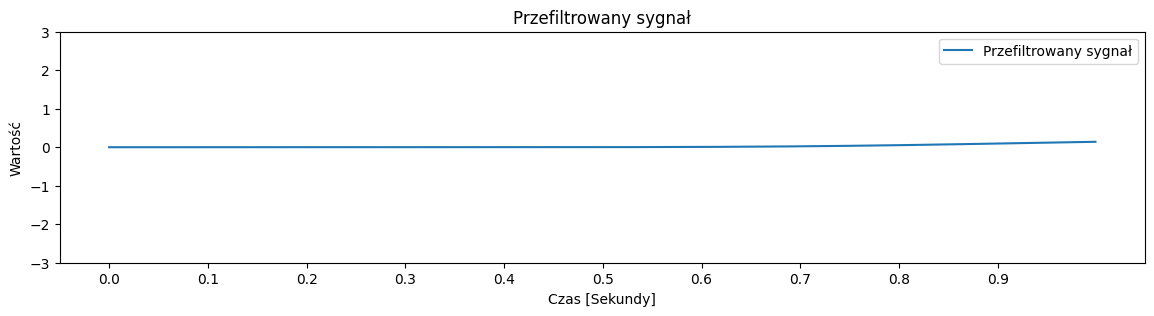

In [28]:
freqPassFilter = FrequencyPassFilterHandler(
    frequency_pass_type=FrequencyPassType.LOW, 
    cutoff_low=1, 
    cutoff_high=12, 
    sampling=1000,
    signal=np.array([sin_combined]),
    order=10,
)

freqPassFilter.read_signal_from_file("Dane/sin1_1_1000.csv")
freqPassFilter.filter_signal()
freqPassFilter.plot_result()
freqPassFilter.save_filtered_signal("filtered_signal.csv")

# Instrukcja wykorzystania

W niniejszym notatniku znajdują się dwie klasy służące do filtrowania sygnałów metodą za pomocą:
- średniej kroczącej
- okna o jądrze gaussowskim
- okna o jądrze blackmana
- okna o jądrze hamminga
- filtru dolnoprzepustowego
- filtru górnoprzepustowego
- filtru pasmowoprzepustowego

W celu wykorzystania filtrów bazujących na oknie należy wykorzystać klasę MovingAverageFilterHandler.
Parametry klasy:
- kernel_type - typ okna (FilterType.GAUSSIAN: jądro Gaussowskie, FilterType.BLACKMAN: okno Blackmana, FilterType.HAMMING: okno Hamminga, FilterType.BOX: średnia krocząca)
- kernel_size - rozmiar okna
- sampling - częstotliwość próbkowania
- samples - liczba próbek
- signal - sygnał wejściowy
- selected_channel - numer analizowanego kanału sygnału wejściowego

Parametr "signal" reprezentuje dane w postaci druwymiarowej tablicy biblioteki numPy, w której każda kolumna reprezentuje kolejny kanał sygnału, a każdy wiersz kolejną próbkę sygnału.

Tablicy tej nie trzeba podawać w argumencie, zostanie ona automatycznie uzupełniona po wywołaniu metody read_signal_from_file(path), gdzie "path" to ścieżka do pliku z sygnałem w formacie .csv.

W celu wykorzystania filtrów przepustowych należy wykorzystać klasę FrequencyPassFilterHandler.
Parametry klasy:
- frequency_pass_type - typ filtru (FrequencyPassType.LOW: dolnoprzepustowy, FrequencyPassType.HIGH: górnoprzepustowy, FrequencyPassType.BAND: pasmowoprzepustowy)
- cutoff_low - częstotliwość odcięcia dolna (wykorzystywana przy filtrze dolnoprzepustowym i pasmowoprzepustowym)
- cutoff_high - częstotliwość odcięcia górna (wykorzystywana przy filtrze górnoprzepustowym i pasmowoprzepustowym)
- sampling - częstotliwość próbkowania
- samples - liczba próbek
- signal - sygnał wejściowy
- order - rząd filtru
- selected_channel - numer analizowanego kanału sygnału wejściowego

Parametr "signal" oraz wczytywanie danych z pliku odbywa się analogicznie jak w przypadku klasy MovingAverageFilterHandler.

## Schemat wykorzystania filtrów
1. Utworzenie obiektu klasy MovingAverageFilterHandler lub FrequencyPassFilterHandler
2. Ustawienie wymaganych parametrów:
    - dla klasy MovingAverageFilterHandler:
        - kernel_type
        - kernel_size
        - sampling
        - samples
        - selected_channel
    - dla klasy FrequencyPassFilterHandler:
        - frequency_pass_type
        - cutoff_low (w przypadku filtru dolnoprzepustowego i pasmowoprzepustowego)
        - cutoff_high (w przypadku filtru górnoprzepustowego i pasmowoprzepustowego)
        - sampling
        - samples
        - order
        - selected_channel
3. Wczytanie sygnału z pliku za pomocą metody read_signal_from_file(path)
4. Wywołanie metody filter_signal()
5. Wizualizacja sygnału za pomocą metody plot_signal()
6. Wywołanie metody save_signal_to_file(path), w celu zapisania przefiltrowanego sygnału do pliku

## Przykład wykorzystania
```python
# Wybór typu filtru (wykorzystanie odpowiedniej klasy i podanie odpowiedniego typu kernela bądź odcięcia),
# oraz ustawienie parametrów
freqPassFilter = FrequencyPassFilterHandler(
    frequency_pass_type=FrequencyPassType.LOW, 
    cutoff_low=1, 
    cutoff_high=12, 
    sampling=1000,
    order=10,
)

# Wczytanie sygnału z pliku
freqPassFilter.read_signal_from_file("Dane/sin1_1_1000.csv")

# Filtracja sygnału
freqPassFilter.filter_signal()

# Wyświetlenie wejściowego i przefiltrowanego sygnału oraz odpowiedzi charakteryzujcych wybrany filtr
freqPassFilter.plot_result()

# Zapisanie przefiltrowanego sygnału do pliku
freqPassFilter.save_filtered_signal("filtered_signal.csv")
```